In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
import pandas as pd
import time

In [ ]:
# read the data
train_df = pd.read_csv("./explore_cds/train.csv") # from 2015-01-02 to 2019-05-31 (80797 rows)
val_df = pd.read_csv("./explore_cds/validation.csv") # from 2019-06-01 to 2020-03-31 (24184 rows)
test_df = pd.read_csv("./explore_cds/test.csv") # from 2020-04-01 to 2020-06-11 (9043 rows)

In [ ]:
# shuffle the data
from sklearn.utils import shuffle
train_df = shuffle(train_df)
val_df = shuffle(val_df)
test_df = shuffle(test_df)

In [ ]:
train_df

,Unnamed: 0,title,date,PX10,stock,Company
9911,2823,"Jim Cramer Gives His Opinion On Humana, Alibab...",2015-08-06,0.001042,AET,Aetna Inc
7328,44813,U.S. Army Gives Green Light to General Dynamic...,2015-06-08,0.034086,GD,General Dynamics Corp
80623,53542,Shares of several technology companies are tra...,2019-05-29,-0.064325,IBM,International Business Machines Corp
19832,49563,Google Cloud Platform Signs Home Depot as Clie...,2016-03-22,0.005032,HD,Home Depot Inc The
40483,83336,The Lucky Beneficiaries Of Tax Day,2017-04-20,-0.001756,NOC,Northrop Grumman Corp
...,...,...,...,...,...,...
32703,52869,"IBM, NVIDIA Collaborate on World's Fastest Dee...",2016-11-14,0.033142,IBM,International Business Machines Corp
33679,81942,18 Stocks Moving In Monday's Pre-Market Session,2016-12-05,-0.010772,NEM,Newmont Mining Corp
71858,57201,"Bangladesh To Collect, Test Samples Of Johnson...",2018-12-21,-0.014501,JNJ,Johnson Johnson
13563,99917,Molson Coors Shares Spike,2015-11-10,0.002723,TAP,Molson Coors Brewing Co


In [ ]:
show_df = train_df.drop('Unnamed: 0',axis=1).rename(columns={"PX10":"Percentage change in CDS"})

In [ ]:
# reset the index
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [ ]:
show_df

,title,date,Percentage change in CDS,stock,Company
9911,"Jim Cramer Gives His Opinion On Humana, Alibab...",2015-08-06,0.001042,AET,Aetna Inc
7328,U.S. Army Gives Green Light to General Dynamic...,2015-06-08,0.034086,GD,General Dynamics Corp
80623,Shares of several technology companies are tra...,2019-05-29,-0.064325,IBM,International Business Machines Corp
19832,Google Cloud Platform Signs Home Depot as Clie...,2016-03-22,0.005032,HD,Home Depot Inc The
40483,The Lucky Beneficiaries Of Tax Day,2017-04-20,-0.001756,NOC,Northrop Grumman Corp
...,...,...,...,...,...
32703,"IBM, NVIDIA Collaborate on World's Fastest Dee...",2016-11-14,0.033142,IBM,International Business Machines Corp
33679,18 Stocks Moving In Monday's Pre-Market Session,2016-12-05,-0.010772,NEM,Newmont Mining Corp
71858,"Bangladesh To Collect, Test Samples Of Johnson...",2018-12-21,-0.014501,JNJ,Johnson Johnson
13563,Molson Coors Shares Spike,2015-11-10,0.002723,TAP,Molson Coors Brewing Co


In [ ]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 123 kB 5.5 MB/s 
     |████████████████████████████████| 132 kB 44.0 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 8.5 MB 46.0 MB/s 
     |████████████████████████████████| 138 kB 51.5 MB/s 
     |████████████████████████████████| 127 kB 47.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import os 
import json 
import numpy as np 
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
import pandas as pd
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
import copy
import time
import torch.nn.functional as F
from torch.optim import lr_scheduler
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from sklearn.metrics import f1_score

In [ ]:
# extract only cds and news from dataset
def financialPhraseBankDataset(df):
    X, Y  = df['title'].tolist(), df['PX10'].tolist()    
    return [X, Y]

In [ ]:
train_data = financialPhraseBankDataset(train_df)
val_data = financialPhraseBankDataset(val_df)
test_data = financialPhraseBankDataset(test_df)

In [ ]:
train_lists = [train_data[0][:10000],train_data[1][:10000]]
test_lists = [val_data[0][:2000], val_data[1][:2000]]

In [ ]:
# do the tokenizing of the data
class text_dataset(Dataset):
    def __init__(self, x_y_list, vocab_path, max_seq_length=256, vocab = 'base-cased', transform=None):
        self.max_seq_length = max_seq_length
        self.x_y_list = x_y_list
        self.vocab = vocab
        if self.vocab == 'base-cased':
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False, do_basic_tokenize=True)
        elif self.vocab == 'finance-cased':
            self.tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = False, do_basic_tokenize = True)
        elif self.vocab == 'base-uncased':
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, do_basic_tokenize=True) 
        elif self.vocab == 'finance-uncased':
            self.tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = True, do_basic_tokenize = True)
    
    def __getitem__(self,index):
        tokenized_review = self.tokenizer.tokenize(self.x_y_list[0][index])
        
        if len(tokenized_review) > self.max_seq_length:
            tokenized_review = tokenized_review[:self.max_seq_length]
            
        ids_review  = self.tokenizer.convert_tokens_to_ids(tokenized_review)
        
        mask_input = [1]*len(ids_review)
        
        padding = [0] * (self.max_seq_length - len(ids_review))
        ids_review += padding
        mask_input += padding
        
        input_type = [0]*self.max_seq_length  
        
        assert len(ids_review) == self.max_seq_length
        assert len(mask_input) == self.max_seq_length
        assert len(input_type) == self.max_seq_length 
        
        ids_review = torch.tensor(ids_review)
        mask_input =  torch.tensor(mask_input)
        input_type = torch.tensor(input_type)
        sentiment = self.x_y_list[1][index] 
        list_of_labels = [torch.from_numpy(np.array(sentiment))]
        input_feature = {"token_type_ids": input_type, "attention_mask":mask_input, "input_ids":ids_review}
        
        return input_feature, list_of_labels[0]
    
    def __len__(self):
        return len(self.x_y_list[0])

In [ ]:
training_dataset = text_dataset(x_y_list = train_lists, vocab= "finance-uncased", vocab_path = "./FinBERT/analyst_tone/vocab")
test_dataset = text_dataset(x_y_list = test_lists , vocab = "finance-uncased", vocab_path = "./FinBERT/analyst_tone/vocab")

In [ ]:
dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=0), 'val':torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)}

In [ ]:
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BertClassification(nn.Module):
    def __init__(self,train_list, weight_path, num_labels=3, vocab="base-cased"):
        super(BertClassification, self).__init__()
        self.num_labels = num_labels
        self.vocab = vocab 
        self.train_list = train_list
        if self.vocab == "base-cased":
            self.bert = BertModel.from_pretrained(weight_path)
            self.config = BertConfig(vocab_size_or_config_json_file=28996, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

        elif self.vocab == "base-uncased":
            self.bert = BertModel.from_pretrained(weight_path)
            self.config = BertConfig(vocab_size_or_config_json_file=30522, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
            
        elif self.vocab == "finance-cased":
            self.bert = BertModel.from_pretrained(weight_path)
            self.config = BertConfig(vocab_size_or_config_json_file=28573, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

        elif self.vocab =="finance-uncased":
            self.bert = BertModel.from_pretrained(weight_path)
            self.freeze_layers(self.train_list,self.bert)
            self.config = BertConfig(vocab_size_or_config_json_file=30873, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
        
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        nn.init.xavier_normal(self.classifier.weight)
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None, graphEmbeddings=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
       
        logits = self.classifier(pooled_output)
            
        return logits
      
    def freeze_layers(self, train_list, model):
        for key, weight in iter(model.named_parameters()):
            for trainable in self.train_list:
                if(key.startswith(trainable)==False):
                    weight.requires_grad=False

In [ ]:
class dense_opt():
    def __init__(self, model):
        super(dense_opt, self).__init__()
        self.lrlast = .001
        self.lrmain = .00001
        self.optim = optim.Adam(
        [ {"params":model.bert.parameters(),"lr": self.lrmain},
          {"params":model.classifier.parameters(), "lr": self.lrlast},
       ])
    
    def get_optim(self):
        return self.optim

In [ ]:
train_list=["encoder.layer.10", "encoder.layer.11", "pooler"]

In [ ]:
fine_tuned = torch.load('./FinBERT/analyst_tone/fine_tuned.pth',map_location='cuda:0')

In [ ]:
model = BertClassification(train_list,weight_path='./FinBERT/analyst_tone/pretrained_weights', num_labels=3, vocab="finance-uncased")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


In [ ]:
model.load_state_dict(fine_tuned)

<All keys matched successfully>

In [ ]:
model.classifier = nn.Linear(768,1)

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)

In [ ]:
def train_model(model, model_type, path, criterion, optimizer, scheduler, device, num_epochs=100, early_stopping = 100):
    model.to(device)
    log_file =  os.path.join(path, "{}_log.txt".format(model_type))
    model_path = os.path.join(path, "{}.pth".format(model_type))
    wo= open(log_file, 'w')
    
    print('starting')
    wo.write('starting \n')
    best_loss = 100
    best_accuracy = 0 
    best_f1 = 0
    early_stopping_count = 0
    
    for epoch in range(num_epochs):
        if (early_stopping_count >= early_stopping):
            break 
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        wo.write('Epoch {}/{} \n'.format(epoch, num_epochs - 1))
        print('-' * 10)
        wo.write('-' * 10 + "\n")

        # Each epoch has a training and validation phase
        since = time.time()
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                early_stopping_count +=1

            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            sentiment_corrects = 0
            mae_running_loss = 0
            actual = torch.tensor([]).long().to(device)
            pred = torch.tensor([]).long().to(device)
            # Iterate over data.
            for inputs, sentiment in dataloaders_dict[phase]:
           
                input_ids = inputs["input_ids"].to(device)
                token_type_ids = inputs["token_type_ids"].to(device)
                attention_mask  =  inputs["attention_mask"].to(device)
                sentiment = sentiment.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(input_ids, token_type_ids, attention_mask)
                    loss = criterion(outputs[0], sentiment.float())
                    mae_loss = criterion(outputs[0], sentiment.float())
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * input_ids.size(0)
                mae_running_loss += loss.item() * input_ids.size(0)
                # sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == torch.max(sentiment, 1)[1])
                # actual = torch.cat([actual, torch.max(outputs, 1)[1]], dim=0)
                # pred= torch.cat([pred, torch.max(sentiment, 1)[1]], dim=0)
            start_time = time.time()
            epoch_loss = running_loss / dataset_sizes[phase]
            mae_epoch_loss = mae_running_loss / dataset_sizes[phase]
            if(phase=='train'):
              print(f"training loss: {epoch_loss}")
              print(f"mae training loss: {mae_epoch_loss}")
            elif(phase=='val'):
              print(f"validation loss: {epoch_loss}")
              print(f"mae validation loss: {mae_epoch_loss}")
        print(f"Time used: {time.time()-since}\n")

            # sentiment_acc = sentiment_corrects.double() / dataset_sizes[phase]
            # assert(len(actual) == len(pred))
            # assert(len(actual) == dataset_sizes[phase])
            # f1 = f1_score(actual.cpu().numpy(), pred.cpu().numpy(), average='weighted')
            
            # print('{} total loss (avg): {:.4f} '.format(phase,epoch_loss ))
            # wo.write('{} total loss: {:.4f} \n'.format(phase,epoch_loss ))
            # print('{} sentiment_acc: {:.4f}'.format(phase, sentiment_acc))
            # wo.write('{} sentiment_acc: {:.4f} \n'.format(phase, sentiment_acc))
            # print('{} f1-score: {:.4f}'.format(phase, f1))
            # wo.write('{} f1-score:: {:.4f} \n'.format(phase, f1))

    #         if phase == 'val' and epoch_loss < best_loss:
    #             print('saving with loss of {}'.format(epoch_loss),
    #                   'improved over previous {}'.format(best_loss))
    #             wo.write('saving with loss of {} \n'.format(epoch_loss))
    #             wo.write('improved over previous {} \n'.format(best_loss))
    #             wo.write("\n")
    #             best_loss = epoch_loss
    #             best_accuracy = sentiment_acc
    #             best_f1 = f1
    #             best_model_wts = copy.deepcopy(model.state_dict())
    #             torch.save(model.state_dict(), model_path)
    #             early_stopping_count = 0
    #     print()

    # time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(
    #     time_elapsed // 60, time_elapsed % 60))
    # wo.write('Training complete in {:.0f}m {:.0f}s \n'.format(
    #     time_elapsed // 60, time_elapsed % 60))

    # print('Best val Acc: {:8f}'.format(float(best_accuracy)))
    # wo.write('Best val Acc: {:8f} \n'.format(float(best_accuracy)))
    # print('Best val f1: {:8f}'.format(float(best_f1)))
    # wo.write('Best val f1: {:8f} \n'.format(float(best_f1)))
    # wo.close()
    
    # # load best model weights
    # model.load_state_dict(best_model_wts)

    # return best_accuracy, best_f1

In [ ]:
train_model(model, "FinBert_FinVocab_Uncased", './FinBERT/output', criterion, optim, exp_lr_scheduler, device, num_epochs=10)

starting
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


training loss: 0.0403068575025345
mae training loss: 0.0403068575025345
validation loss: 0.06174800373989406
mae validation loss: 0.06174800373989406
Time used: 242.78842759132385

Epoch 1/9
----------
training loss: 0.04039541443129032
mae training loss: 0.04039541443129032
validation loss: 0.03975932700435372
mae validation loss: 0.03975932700435372
Time used: 250.58066153526306

Epoch 2/9
----------
training loss: 0.03924311207632628
mae training loss: 0.03924311207632628
validation loss: 0.04106393983427518
mae validation loss: 0.04106393983427518
Time used: 250.5566861629486

Epoch 3/9
----------
training loss: 0.04181058798400065
mae training loss: 0.04181058798400065
validation loss: 0.03758393188370218
mae validation loss: 0.03758393188370218
Time used: 250.66427206993103

Epoch 4/9
----------
training loss: 0.008344918465488496
mae training loss: 0.008344918465488496
validation loss: 0.022471711245247175
mae validation loss: 0.022471711245247175
Time used: 250.01229047775269



In [ ]:
torch.save(model, "FinBERT/new_output_model.pth")

In [ ]:
model = torch.load("FinBERT/new_output_model.pth")

## Test the model

In [ ]:
sentences = test_data[0]
labels =  test_data[1]

In [ ]:
res_df = test_df.rename(columns={'PX10': 'target'})

In [ ]:
tokenizer = training_dataset.tokenizer
max_seq_length = 512

In [ ]:
pred = []

In [ ]:
model.eval()
for id, rows  in res_df.iterrows():
    sent = rows["title"] 
    tokenized_sent = tokenizer.tokenize(sent)
    if len(tokenized_sent) > max_seq_length:
        tokenized_sent = tokenized_sent[:max_seq_length]
    
    ids_review  = tokenizer.convert_tokens_to_ids(tokenized_sent)
    mask_input = [1]*len(ids_review)        
    padding = [0] * (max_seq_length - len(ids_review))
    ids_review += padding
    mask_input += padding
    input_type = [0]*max_seq_length
    
    input_ids = torch.tensor(ids_review).to(device).reshape(-1, max_seq_length)
    attention_mask =  torch.tensor(mask_input).to(device).reshape(-1, max_seq_length)
    token_type_ids = torch.tensor(input_type).to(device).reshape(-1, max_seq_length)
    
    with torch.set_grad_enabled(False):
        outputs = model(input_ids, token_type_ids, attention_mask)
        pred.append(outputs[0].item())
        # print(sent, '\nFinBERT predicted cds_per: ', labels[torch.argmax(outputs).item()], '\n')

NameError: ignored

In [ ]:
res_df["pred"] = pred

In [ ]:
res_df

,Unnamed: 0,title,date,target,stock,Company,pred
0,111743,Investor Movement Index Summary: April 2020,2020-05-04,-0.001419,WFC,Wells Fargo Co,-0.005922
1,793,"'FAANG Stocks Are Strong Once Again,' Facebook...",2020-05-26,-0.020136,AAPL,Apple Inc,0.014411
2,19966,Shares of several industrial companies are tra...,2020-04-06,-0.017108,CAR,Avis Budget,-0.007723
3,111698,Hearing Wells Fargo's Asset Cap is Being Lifte...,2020-04-08,0.122438,WFC,Wells Fargo Co,-0.013068
4,41234,"Benzinga's Top Upgrades, Downgrades For June 5...",2020-06-05,-0.010066,ETR,Entergy,-0.000233
...,...,...,...,...,...,...,...
9038,104077,Tyson Foods To Close Iowa Pork Plant After 555...,2020-05-29,0.031377,TSN,Tyson Foods Inc,0.031339
9039,732,Apple Files Final Pricing Term Sheet For Offer...,2020-05-05,0.003023,AAPL,Apple Inc,0.010824
9040,50715,Shares of several global financial services co...,2020-04-20,0.159837,HIG,Hartford Financial Services Group Inc,0.021533
9041,113466,"Earnings Scheduled For May 5, 2020",2020-05-05,0.018877,WU,Western Union Co The,0.001357


In [ ]:
res_df.to_csv("FinBERT/new_result.csv")

In [ ]:
res_df = pd.read_csv("FinBERT/new_result.csv")

In [ ]:
grouped_df = res_df.groupby("date").mean()

In [ ]:
grouped_df

,Unnamed: 0.1,target,pred
date,,,
2020-04-01,54757.836735,0.026507,0.016510
2020-04-02,61534.673367,0.022559,0.009669
2020-04-03,62589.526946,0.030861,0.009529
2020-04-06,57748.593750,-0.023478,0.005101
2020-04-07,61131.966981,-0.055934,0.006823
2020-04-08,54673.162304,-0.003024,0.007964
2020-04-09,59749.045226,-0.094606,0.007599
2020-04-10,69105.916667,-0.011503,0.014350
2020-04-13,52734.025253,-0.010148,0.013464


In [ ]:
grouped_df = grouped_df.drop('Unnamed: 0.1',axis=1)

Text(0, 0.5, 'Percentage change in CDS')

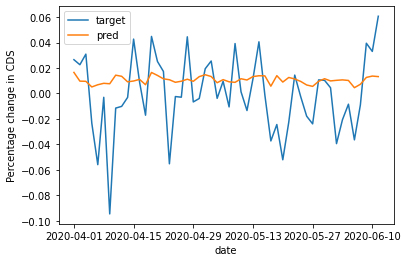

In [ ]:
ax = grouped_df.plot()
ax.set_ylabel("Percentage change in CDS")